# Spykshark decoding with Trodes data

- the purpose of the notebook is to demonstrate one way to use filterframework data with spykshrk decoding using loren_frank_data_processing as a io with custom converters


The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython



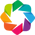

In [71]:
import pandas as pd
import numpy as np
import scipy as sp
import json
import os
import functools
from IPython.display import display
import math

import sys
sys.path.insert(0, '/home/droumis/Src/loren_frank_data_processing/')
sys.path.insert(0, '/home/droumis/Src/spykshrk_realtime/')
sys.path.insert(0, '/home/droumis/Src/Roumis_2018/')
import src.converters as lfconvert
import loren_frank_data_processing as lfdp
# import replay_classification as replay
import ripple_detection as ripple


# from spykshrk.util import AttrDict
from spykshrk.franklab.data_containers import RippleTimes
import spykshrk.franklab.filterframework_util as ff_util
# from spykshrk.realtime.simulator import nspike_data
from spykshrk.franklab.pp_decoder.util import gaussian, normal2D, apply_no_anim_boundary, simplify_pos_pandas, \
                                                normal_pdf_int_lookup
from spykshrk.franklab.pp_decoder.pp_clusterless import OfflinePPDecoder, OfflinePPEncoder
from spykshrk.franklab.data_containers import EncodeSettings, DecodeSettings, SpikeObservation, \
                                                         LinearPosition, StimLockout, Posteriors, \
                                                         FlatLinearPosition, SpikeWaves, SpikeFeatures, \
                                                         pos_col_format, DayEpochTimeSeries
from spykshrk.franklab.pp_decoder.visualization import DecodeVisualizer
from spykshrk.franklab.pp_decoder.decode_error import LinearDecodeError
import spykshrk
import dask
import dask.dataframe as dd
import dask.array as da
import dask.diagnostics as diag

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import patches
import holoviews as hv
from holoviews.operation.datashader import aggregate, shade, datashade, dynspread, regrid
from holoviews.operation import decimate
import seaborn as sns

%matplotlib inline
%reload_ext autoreload
%autoreload 2
%load_ext Cython

hv.notebook_extension('bokeh')
mpl.rcParams.update({'font.size': 14})
# hv.Store.renderers['bokeh'].webgl = True

pd.set_option('display.precision', 4)
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 15)
idx = pd.IndexSlice

trying multithredded instead of multiprocessor

In [72]:
# from dask.distributed import Client, LocalCluster
# import multiprocessing

# dask.set_options(get=dask.multiprocessing.get)
# dask.set_options(get=dask.multiprocessing.get)
# min_worker_memory = 1e9

In [73]:
dask.set_options(get=dask.threaded.get)

In [74]:
# #shut multiprocessing workers down with:
# from dask.context import _globals
# pool = _globals.pop('pool')  # remove the pool from globals to make dask create a new one
# pool.close()
# pool.terminate()
# pool.join()

In [75]:
import platform
computername = platform.node()

In [76]:
animal_id = 'JZ1'
day, epoch = [4, 2]
ripple_area = 'ca1'
mu_areas = ['ca1', 'mec']
if computername == 'virga-02':
    animals = {
        'JZ1': lfdp.Animal(short_name='JZ1', directory='/data2/demetris/JZ1/filterframework')}
elif computername == 'derecho':
    animals = {
        'JZ1': lfdp.Animal(short_name='JZ1', directory='/home/droumis/Src/Roumis_2018/Raw-Data/JZ1')}
else:
    print('barf')

date = 20161117
areas = ['ca1']
mark_variables = ['channel_1_max', 'channel_2_max', 'channel_3_max',
                  'channel_4_max']
sleep_index = ('JZ1', 4, 3)
epoch_index = ('JZ1', 4, 2)
# ntrode_key = ('JZ1', 4, 2, 16)

# load trodes data from filterframework (.mat) into pd with lfdp

In [77]:
# test
# mu_filenames = lfdp.multiunit.get_multiunit_filename(ntrode_key, animals)
# assert(mu_filenames is not None)

ntrode_df = lfdp.make_tetrode_dataframe(animals)
ntrode_keys = ntrode_df.xs(epoch_index, drop_level=False).index.values
ca1_ntrode_keys_df = ntrode_df.xs(epoch_index, drop_level=False).query('area == "ca1"')
ca1_ntrode_keys = ca1_ntrode_keys_df.index.values
mec_ntrode_keys_df = ntrode_df.xs(epoch_index, drop_level=False).query('area == "mec"')
mec_ntrode_keys = mec_ntrode_keys_df.index.values

In [78]:
#sleep_ca1_ntrode_keys = ntrode_df.xs(sleep_index, drop_level=False).query('area=="ca1"').index.values
#sleep_mec_ntrode_keys = ntrode_df.xs(sleep_index, drop_level=False).query('area=="mec"').index.values

In [79]:
# sleep_ca1_ntrode_keys_df = sleep_ntrode_keys_df.query('area == "ca1"')
# sleep_mec_ntrode_keys_df = sleep_ntrode_keys_df.query('area == "mec"')

In [80]:
# sleep_position_variables = ['linear_distance', 'trajectory_direction', 'speed']
# sleep_position_df = lfdp.get_interpolated_position_dataframe(sleep_index, animals, time_function=lfdp.position.get_pos_time)
# sleep_position_df['time'] = sleep_position_df.index #add the time index values as another col


In [81]:
# ep4_position_df = lfdp.get_interpolated_position_dataframe(('JZ1', 4, 4), animals, time_function=lfdp.position.get_pos_time)
# ep4_position_df['time'] = ep4_position_df.index #add the time index values as another col


In [82]:
# track_graph, center_well_id = lfdp.position.make_track_graph(('JZ1', 4, 4), animals)
# ep4_position_df['track_segment_id'] = lfdp.track_segment_classification.classify_track_segments(
#     track_graph, ep4_position_df[['x_position', 'y_position']].values,
#     route_euclidean_distance_scaling=1E-1)
# ep4_position_df['linear_distance'] = lfdp.track_segment_classification.calculate_linear_distance(
#     track_graph, ep4_position_df.track_segment_id , center_well_id, 
#     ep4_position_df[['x_position', 'y_position']].values)

In [83]:
# position_variables = ['linear_distance', 'trajectory_direction', 'speed']
# position_df = lfdp.get_interpolated_position_dataframe(epoch_index, animals, time_function=lfdp.position.get_pos_time)
# position_df['time'] = position_df.index #add the time index values as another col


In [84]:
# %store position_df
%store -r position_df

In [85]:
# hdf = pd.HDFStore('demo.h5') #this actually creates the file in the current directory

# hdf.put('position_df', position_df, format='table', data_columns=True)

# print(hdf['position_df'].shape)

# hdf.close()

# hdf2 = pd.read_hdf('demo.h5', 'position_df',
#                where=['track_segment_id>=0'], columns=['x_position','y_position','linear_position','speed','y_position', 'track_segment_id', 'time'])

In [86]:
# mu_times = []
# for key_num, ntrode_key in enumerate(ntrode_keys):
#     mu_times.append(lfdp.get_multiunit_dataframe(ntrode_key, animals, datastruct='by_day'))

In [87]:
# day=4
# epoch=4
# ep4_mu_times = []
# ep4_ntrode_keys = ntrode_df.query('area=="ca1" & day==@day & epoch==@epoch').index.values
# for key_num, ntrode_key in enumerate():
#      ep4_mu_times.append(lfdp.get_multiunit_dataframe(ntrode_key, animals, datastruct='by_day'))

In [88]:
# sleep_mu_times = []
# for key_num, ntrode_key in enumerate(sleep_ntrode_keys):
#     sleep_mu_times.append(lfdp.get_multiunit_dataframe(ntrode_key, animals, datastruct='by_day'))

In [89]:
# %store mu_times
# %store sleep_mu_times
%store -r sleep_mu_times
%store -r mu_times

In [90]:
# lfpinterped_position_df = lfdp.get_interpolated_position_dataframe(epoch_index, animals)

In [91]:
# sleep_lfpinterped_position_df = lfdp.get_interpolated_position_dataframe(sleep_index, animals)

In [92]:
# sleep_hippocampus_lfps = lfdp.get_LFPs(sleep_ca1_ntrode_keys_df.index, animals)
# time = sleep_hippocampus_lfps.index
# sampling_frequency = 1500
# sleep_ripple_times = ripple.Kay_ripple_detector(
#         time, sleep_hippocampus_lfps.values, sleep_lfpinterped_position_df.speed.values, sampling_frequency,
#         minimum_duration=pd.Timedelta(milliseconds=15), zscore_threshold=3)

In [93]:
# hippocampus_lfps = lfdp.get_LFPs(ca1_ntrode_keys_df.index, animals)
# time = hippocampus_lfps.index
# sampling_frequency = 1500
# ripple_times = ripple.Kay_ripple_detector(
#         time, hippocampus_lfps.values, lfpinterped_position_df.speed.values, sampling_frequency,
#         minimum_duration=pd.Timedelta(milliseconds=15), zscore_threshold=3)

In [94]:
# hpclfp = hippocampus_lfps.T.set_index(ca1_ntrode_keys_df.index).T

# hpclfp.index = hpclfp.index.total_seconds()

# hpclfp = hpclfp.stack(level=[0,1,2]).reorder_levels(order=['animal', 'day', 'epoch', 'time'])

# hpclfp.columns = hpclfp.columns.astype(str)

In [95]:
# %store sleep_ripple_times
# %store sleep_lfpinterped_position_df
# %store ripple_times
# %store lfpinterped_position_df
# %store -r sleep_ripple_times
# %store -r sleep_lfpinterped_position_df
%store -r hippocampus_lfps
%store -r ripple_times
%store -r lfpinterped_position_df

### reformat to spykshrk data_containers inputs

convert the lfdp pd df's into spykshrk format w custom converters

In [100]:
config_file = '/home/droumis/Src/spykshrk_realtime/config/droumis_test.json'
config = json.load(open(config_file, 'r'))
encode_settings = EncodeSettings(config)
decode_settings = DecodeSettings(config)

In [101]:
encode_settings.mark_kernel_std

20

In [102]:
# ep4_marks_df = SpikeFeatures.create_default(lfconvert.multiunit_to_spykshrk(ep4_mu_times, ep4_ntrode_keys), sampling_rate=1e5)

# ep4_linpos_df = FlatLinearPosition.create_default(lfconvert.linear_position_to_spykshrk(ep4_position_df, ntrode_keys[0]),
#                                                    sampling_rate=1e5, arm_coord=encode_settings.arm_coordinates)

In [103]:
marks_df = SpikeFeatures.create_default(lfconvert.multiunit_to_spykshrk(mu_times, ntrode_keys), sampling_rate=1e5)

linpos_df = FlatLinearPosition.create_default(lfconvert.linear_position_to_spykshrk(position_df, ntrode_keys[0]),
                                                   sampling_rate=1e5, arm_coord=encode_settings.arm_coordinates)

ripples_df = RippleTimes.create_default(lfconvert.ripples_to_spykshrk(ripple_times, day=4, epoch=2), time_unit=1e5)

# sleep_ca1_spyk_marks_df = lfconvert.multiunit_to_spykshrk(sleep_mu_times, sleep_ca1_ntrode_keys)
# sleep_mec_spyk_marks_df = lfconvert.multiunit_to_spykshrk(sleep_mu_times, sleep_mec_ntrode_keys)

In [104]:
# linpos = FlatLinearPosition.create_default(
#         spyk_linpos_df, sampling_rate=1e5, arm_coord=encode_settings.arm_coordinates)

trim ntrodes to tetrodes, separate by area

In [105]:
ca1_ntrodes= ntrode_df.xs(epoch_index, drop_level=False).query('area=="ca1"').index.get_level_values(level='tetrode_number')
mec_ntrodes= ntrode_df.xs(epoch_index, drop_level=False).query('area=="mec"').index.get_level_values(level='tetrode_number')

ca1_marks = marks_df.query('elec_grp_id in @ca1_ntrodes').loc[:,'c00':'c03'].copy()
mec_marks = marks_df.query('elec_grp_id in @mec_ntrodes').loc[:,'c00':'c03'].copy()

get suprathreshold spikes

In [106]:
# ca1_marks_frac = ca1_marks.sample(frac=.1)
# mec_marks = mec_marks.sample(frac=1)

ca1_marks_frac = ca1_marks.iloc[np.nonzero(np.any(ca1_marks.values > 60, axis=1))].copy()
mec_marks_frac = mec_marks.iloc[np.nonzero(np.any(mec_marks.values > 60, axis=1))].copy()

In [107]:
# ep4_ca1_marks_frac = ep4_marks_df.iloc[np.nonzero(np.any(ep4_marks_df.values > 60, axis=1))].copy()

# ep4_decoding_marks = ep4_ca1_marks_frac.query('time>4700 & time<4800')

separate encoding from decoding spikes and get linpos for each encodig spike

In [108]:
ca1_mark_linpos = linpos_df.get_irregular_resampled(ca1_marks_frac)
ca1_encoding_marks = ca1_marks_frac[(ca1_mark_linpos.linvel_flat > 4).values]
ca1_encoding_linpos = ca1_mark_linpos[ca1_mark_linpos.linvel_flat > 4]
ca1_decoding_marks = ca1_marks_frac[(ca1_mark_linpos.linvel_flat > 0).values]

In [109]:
ca1_decoding_marks = ca1_decoding_marks.query('time>0')
ca1_encoding_marks = ca1_encoding_marks.query('time<1700 | time>1900')

In [110]:
mec_mark_linpos = linpos_df.get_irregular_resampled(mec_marks_frac)
mec_encoding_marks = mec_marks_frac[(mec_mark_linpos.linvel_flat > 4).values]
mec_encoding_linpos = mec_mark_linpos[mec_mark_linpos.linvel_flat > 4]
mec_decoding_marks = mec_marks_frac[(mec_mark_linpos.linvel_flat > 0).values]

In [111]:
mec_decoding_marks = mec_decoding_marks.query('time>0')
mec_encoding_marks = mec_encoding_marks.query('time<1700 | time>1900')

check for good coverage

In [112]:
# fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(25, 10))
# ca1_mark_linpos.reset_index(level='time').plot.scatter(y='linpos_flat', x='time', c='seg_idx', cmap='Set2', ax=axes[0][0], s=2)
# ca1_mark_linpos.get_mapped_single_axis().reset_index(level='time').plot.scatter(y='linpos_flat', x='time', c='seg_idx', cmap='Set2', ax=axes[1][0], s=2)
# ca1_mark_linpos.reset_index(level='time').plot.scatter(y='linvel_flat', x='time', c='linvel_flat', cmap='copper', ax=axes[2][0], s=2)
# mec_mark_linpos.reset_index(level='time').plot.scatter(y='linpos_flat', x='time', c='seg_idx', cmap='Set2', ax=axes[0][1], s=2)
# mec_mark_linpos.get_mapped_single_axis().reset_index(level='time').plot.scatter(y='linpos_flat', x='time', c='seg_idx', cmap='Set2', ax=axes[1][1], s=2)
# mec_mark_linpos.reset_index(level='time').plot.scatter(y='linvel_flat', x='time', c='linvel_flat', cmap='copper', ax=axes[2][1], s=2)

In [113]:
# fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 8))
# mec_tet_linflat.reset_index(level='time').plot.scatter(y='linpos_flat', x='time', c='seg_idx', cmap='Set2', ax=axes[0], s=2)
# mec_tet_linflat.reset_index(level='time').plot.scatter(y='linvel_flat', x='time', c='linvel_flat', cmap='copper', ax=axes[1], s=2)

In [114]:
# try:
#     del ca1_encoder
# except:
#     pass
# ep4_ca1_encoder = OfflinePPEncoder(linflat=ca1_encoding_linpos.get_mapped_single_axis(),
#                                enc_spk_amp=ca1_encoding_marks,
#                                dec_spk_amp=ep4_decoding_marks,
#                                encode_settings=encode_settings,
#                                decode_settings=decode_settings,
#                                dask_worker_memory=5e9,
#                                dask_memory_utilization=.8)

# ep4_ca1_encoder.run_encoder()

In [116]:
try:
    del ca1_encoder
except:
    pass
ca1_encoder = OfflinePPEncoder(linflat=linpos_df.get_mapped_single_axis(),
                               enc_spk_amp=ca1_encoding_marks,
                               dec_spk_amp=ca1_decoding_marks,
                               encode_settings=encode_settings,
                               decode_settings=decode_settings,
                               dask_worker_memory=5e9,
                               dask_memory_utilization=.8)

ca1_encoder.run_encoder()

[autoreload of spykshrk.franklab.data_containers failed: Traceback (most recent call last):
  File "/home/droumis/anaconda3/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
RecursionError: maximum recursion depth exceeded
]
[autoreload of spykshrk.franklab.data_containers failed: Traceback (most recent call last):
  File "/home/droumis/anaconda3/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
RecursionError: maximum recursion depth exceeded
]
16:01:45 [INFO] spykshrk.franklab.pp_decoder.pp_clusterless: Dask chunksize: 1162
16:01:45 [INFO] spykshrk.franklab.pp_decoder.pp_clusterless: Memory utilization at: 80.0%
16:01:45 [INFO] spykshrk.franklab.pp_decoder.pp_clusterless: Expected worker peak memory usage: 3812.12 MB
INFO:root:Setting up encoder dask task.
INFO:root:Running compute tasks on dask workers.


In [117]:
try:
    del mec_encoder
except:
    pass
mec_encoder = OfflinePPEncoder(linflat=linpos_df.get_mapped_single_axis(),
                               enc_spk_amp=mec_encoding_marks,
                               dec_spk_amp=mec_decoding_marks,
                               encode_settings=encode_settings,
                               decode_settings=decode_settings,
                               dask_worker_memory=5e9,
                               dask_memory_utilization=.8)
mec_encoder.run_encoder()

16:28:10 [INFO] spykshrk.franklab.pp_decoder.pp_clusterless: Dask chunksize: 26169
16:28:10 [INFO] spykshrk.franklab.pp_decoder.pp_clusterless: Memory utilization at: 80.0%
16:28:10 [INFO] spykshrk.franklab.pp_decoder.pp_clusterless: Expected worker peak memory usage: 3814.58 MB
INFO:root:Setting up encoder dask task.
INFO:root:Running compute tasks on dask workers.


In [118]:
# %store ca1_encoder
# %store mec_encoder
# %store -r ca1_encoder_results
# %store -r mec_encoder_results

get encoding results into spykshrk decoder friendly input format

In [119]:
# [ca1_encoder.results[tet_ii].set_index(ntrode_grp.index, inplace=True) for tet_ii, (tet_id, ntrode_grp) in enumerate(ca1_decoding_marks.groupby('elec_grp_id'))]

In [120]:
# [ca1_encoder.results[tet_ii].set_index(ntrode_grp.index, inplace=True) for tet_ii, (tet_id, ntrode_grp) in enumerate(ca1_decoding_marks.groupby('elec_grp_id'))]
ca1_encoder.observ_obj = SpikeObservation(pd.concat(ca1_encoder.results).sort_index(level=['day', 'epoch', 'timestamp', 'elec_grp_id'])).reset_index(level='elec_grp_id')

In [121]:
# ep4_ca1_encoder.observ_obj = SpikeObservation(pd.concat(ep4_ca1_encoder.results).sort_index(level=['day', 'epoch', 'timestamp', 'elec_grp_id'])).reset_index(level='elec_grp_id')

In [122]:
# [mec_encoder.results[tet_ii].set_index(ntrode_grp.index, inplace=True) for tet_ii, (tet_id, ntrode_grp) in enumerate(mec_decoding_marks.groupby('elec_grp_id'))]
mec_encoder.observ_obj = SpikeObservation(pd.concat(mec_encoder.results).sort_index(level=['day', 'epoch', 'timestamp', 'elec_grp_id'])).reset_index(level='elec_grp_id')


# Decode

In [123]:
# %%time
# time_bin_size = 100
# decode_settings = DecodeSettings(config)
# ca1_decoder = OfflinePPDecoder(observ_obj=ca1_encoder.observ_obj,
#                                trans_mat=ca1_encoder.trans_mat['uniform'],
#                                prob_no_spike=ca1_encoder.prob_no_spike,
#                                encode_settings=encode_settings,
#                                decode_settings=decode_settings,  
#                                time_bin_size=time_bin_size)
# ca1_posteriors = ca1_decoder.run_decoder()

In [124]:
# time_bin_size = 10
# ep4_ca1_decoder = OfflinePPDecoder(observ_obj = ep4_ca1_encoder.observ_obj,
#                                trans_mat = ep4_ca1_encoder.trans_mat['simple'],
#                                prob_no_spike = ep4_ca1_encoder.prob_no_spike,
#                                encode_settings=encode_settings,
#                                decode_settings=decode_settings,  
#                                time_bin_size=time_bin_size)
# ep4_ca1_posteriors = ep4_ca1_decoder.run_decoder()

In [125]:
time_bin_size = 300
learned_ca1_decoder = OfflinePPDecoder(observ_obj=ca1_encoder.observ_obj,
                               trans_mat=ca1_encoder.trans_mat['simple'],
                               prob_no_spike=ca1_encoder.prob_no_spike,
                               encode_settings=encode_settings,
                               decode_settings=decode_settings,  
                               time_bin_size=time_bin_size)
learned_ca1_posteriors = learned_ca1_decoder.run_decoder()

Beginning likelihood calculation
Beginning posterior calculation


In [126]:
time_bin_size = 300
learned_mec_decoder = OfflinePPDecoder(observ_obj=mec_encoder.observ_obj,
                               trans_mat=mec_encoder.trans_mat['simple'],
                               prob_no_spike=mec_encoder.prob_no_spike,
                               encode_settings=encode_settings,
                               decode_settings=decode_settings,  
                               time_bin_size=time_bin_size)
learned_mec_posteriors = learned_mec_decoder.run_decoder()

Beginning likelihood calculation
Beginning posterior calculation


In [127]:
# %%time
# # mec_spikes=mec_observ_obj.query('time>1840 & time<1940')
# mec_decoder = OfflinePPDecoder(lin_obj=mec_encoder.linflat, observ_obj=mec_spikes,
#                            encode_settings=encode_settings, decode_settings=decode_settings, 
#                            which_trans_mat='simple', time_bin_size=time_bin_size)
# mec_posteriors = mec_decoder.run_decoder()

In [128]:
# %store mec_posteriors
# %store ca1_posteriors
# # %store -r ca1_posteriors
# # %store -r mec_posteriors

# Vizz

In [129]:
# # rip_post = posteriors.query('ripple_grp == 0').get_distribution_view()
# # linpos['time'] = linpos.index.get_level_values(level='time')
# # linflat = linpos.get_mapped_single_axis()
# ca1_dec_viz = DecodeVisualizer(
#     ca1_posteriors, linpos=linpos, enc_settings=encode_settings, riptimes=shrk_rips)
# # mec_dec_viz = DecodeVisualizer(
# #     mec_posteriors, linpos=linflat, enc_settings=encode_settings, riptimes=shrk_rips)

In [130]:
# data20+'scratch.h5'

# data20 = '/opt/data20/scratch/'

# hdf = pd.HDFStore(data20+'scratch.h5')

# post_df = pd.DataFrame(learned_ca1_posteriors)

# hdf.put('ca1_posteriors', learned_ca1_posteriors, format='table', data_columns=True)

# hdf.close()

In [131]:
# ep4_ca1_dec_viz = DecodeVisualizer(
#     ep4_ca1_posteriors,
#     linpos=ep4_linpos_df.get_mapped_single_axis(),
#     enc_settings=encode_settings)

In [132]:
learned_ca1_dec_viz = DecodeVisualizer(
    learned_ca1_posteriors,
    linpos=linpos_df.get_mapped_single_axis(),
    enc_settings=encode_settings,
    riptimes=ripples_df)

learned_mec_dec_viz = DecodeVisualizer(
    learned_mec_posteriors,
    linpos=linpos_df.get_mapped_single_axis(),
    enc_settings=encode_settings,
    riptimes=ripples_df)

values = np.arange(1600, 2700, 100)

# arange(ca1_dec_viz.posteriors.index.get_level_values('time')[0],
#                    ca1_dec_viz.posteriors.index.get_level_values('time')[-1],
#                    10)

In [133]:
# learned_mec_posteriors.enc_settings.arm_coordinates = [[10, 40], [45, 95], [100, 150]]
# learned_ca1_posteriors.enc_settings.arm_coordinates = [[10, 40], [45, 95], [100, 150]]

In [134]:
# %%opts Scatter [tools=['hover'] width=1000]
# # hv.Dimension(ripples_df.endtime-ripples_df.starttime)
# hv.Scatter(ripples_df, 'event', ['starttime', 'endtime'])

In [135]:
%%output backend='bokeh' holomap='scrubber'
%%opts RGB {+framewise} [height=500 width=900]
%%opts Points {+framewise} [tools=['hover']] (muted_alpha=0.01 marker='x', color='chartreuse', size=2, alpha=.7)
%%opts Polygons {+framewise} (line_color='grey', fill_color=' darkslategray', alpha=.3, line_width=1)
%%opts Curve {+framewise} (color='dimgrey', alpha=.3  muted_alpha=0.01)
%%opts Overlay [legend_position='bottom' title_format=' ']

stream = hv.streams.RangeXY()
learned_ca1_dmap = learned_ca1_dec_viz.plot_all_dynamic(stream=stream, plt_range=10, slide=10, values=values)
learned_mec_dmap = learned_mec_dec_viz.plot_all_dynamic(stream=stream, plt_range=10, slide=10, values=values)
(learned_ca1_dmap + learned_mec_dmap).cols(1)


:Layout
   .DynamicMap.I  :DynamicMap   [time]
   .DynamicMap.II :DynamicMap   [time]

In [86]:
# %%output backend='bokeh' size=300 holomap='scrubber'
# %%opts RGB {+framewise} [height=100 width=300]
# %%opts Points {+framewise} [height=100 width=300 tools=['hover']] (marker='x', color='chartreuse', size=2, alpha=.6)
# %%opts Polygons {+framewise} (line_color='grey', fill_color=' darkslategray', alpha=.3, line_width=2)
# %%opts Curve {+framewise} (color='dimgrey', alpha=.3)
# stream = hv.streams.RangeXY()
# ep4_dmap = ep4_ca1_dec_viz.plot_all_dynamic(stream=stream, plt_range=10, slide=10)
# ep4_dmap

# vizz based on pandas arrays

In [78]:
from spykshrk.franklab.data_containers import LinearPosition, FlatLinearPosition, SpikeObservation,\
 EncodeSettings, DecodeSettings, Posteriors, pos_col_format

In [90]:
store_posteriors = pd.DataFrame(learned_ca1_posteriors)
store_linpos = pd.DataFrame(linpos_df.get_mapped_single_axis())
store_ripples = pd.DataFrame(ripple_times)


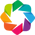

:DynamicMap   [time]

In [66]:
import pandas as pd
from spykshrk.franklab.pp_decoder.visualization import DecodeVisualizer
from spykshrk.franklab.data_containers import LinearPosition, FlatLinearPosition, SpikeObservation,\
 EncodeSettings, DecodeSettings, Posteriors, pos_col_format, RippleTimes, UnitTime
import holoviews as hv
from bokeh.plotting import curdoc
hv.extension('bokeh')
values = np.arange(1840, 1940, 10)

posteriors = pd.read_hdf('/opt/vortex2/data1_backup/demetris/JZ1/crap/testing.h5', 'posteriors')
linpos = pd.read_hdf('/opt/vortex2/data1_backup/demetris/JZ1/crap/testing.h5', 'linpos')
ripples = pd.read_hdf('/opt/vortex2/data1_backup/demetris/JZ1/crap/testing.h5', 'ripples').set_index(['day', 'epoch', 'event'], append=True)

config_file = '/home/droumis/Src/spykshrk_realtime/config/droumis_test.json'
config = json.load(open(config_file, 'r'))
encode_settings = EncodeSettings(config)
decode_settings = DecodeSettings(config)

posteriors = Posteriors.create_default(posteriors, enc_settings=encode_settings, dec_settings=decode_settings)
linpos = FlatLinearPosition.create_default(linpos, sampling_rate=1e5, arm_coord=encode_settings.arm_coordinates)
ripples = RippleTimes.create_default(ripples, time_unit=UnitTime)

hdf.close()

ca1_viz = DecodeVisualizer(posteriors, linpos=linpos, enc_settings=encode_settings, riptimes=ripples)

# %%opts RGB {+framewise} [height=500 width=900]
# %%opts Points {+framewise} [tools=['hover']] (marker='x', color='chartreuse', size=2, alpha=.6)
# %%opts Polygons {+framewise} (line_color='grey', fill_color=' darkslategray', alpha=.3, line_width=2)
# %%opts Curve {+framewise} (color='dimgrey', alpha=.3)
stream = hv.streams.RangeXY()
ca1_dmap = ca1_viz.plot_all_dynamic(stream=stream, plt_range=10, slide=10, values=values)
ca1_dmap

# curdoc().add_root(ca1_dmap)

In [93]:
hdf.put('posteriors', store_posteriors)
hdf.put('linpos', store_linpos)
hdf.put('ripples', store_ripples)
# hdf.put('encode_settings', encode_settings)
# hdf.put('decode_settings', decode_settings)

In [84]:
posteriors = Posteriors.create_default(store_posteriors, enc_settings=encode_settings, dec_settings=decode_settings)

In [ ]:
posteriors.appl

In [ ]:
    def plot_decode_image(self, time, x_range=None, y_range=None, plt_range=10):

        sel_range = [time, time+plt_range]

        if (x_range is None):
            x_range = [time, time+plt_range]

        if (y_range is None):
            y_range = [0, self.enc_settings.pos_bins[-1]]

        x_range = list(x_range)
        #x_range[0] -= plt_range
        #x_range[1] += plt_range
        x_range[0] = max(x_range[0], self.posteriors.get_time_start())
        x_range[1] = min(x_range[1], self.posteriors.get_time_end())

        # post_time = self.posteriors.index.get_level_values('time')
        # img_sel = self.posteriors.get_distribution_view().query("(time > @x_range[0]) & (time < @x_range[1])").values.T
        # img_sel = np.flip(img_sel, axis=0)

        # img = hv.Image(img_sel, bounds=(x_range[0], self.enc_settings.pos_bins[0],
        #                                 x_range[1],
        #                                 self.enc_settings.pos_bins[-1]),
        #                kdims=['time (sec)', 'linpos (cm)'], vdims=['probability'],)

        # img = img.redim(probability={'range': (0, 0.3)})
        # img.extents = (sel_range[0], 0, sel_range[1], self.enc_settings.pos_bins[-1])
        self.post_img.extents = (sel_range[0], 0, sel_range[1], self.enc_settings.pos_bins[-1])

        rgb = shade(regrid(self.post_img, aggregator='max', dynamic=False,
                           x_range=x_range, y_range=y_range), cmap=plt.get_cmap('magma'),
                    normalization='linear', dynamic=False)
        # rgb = shade(regrid(self.post_img, aggregator='mean', dynamic=False,
        #                    x_range=x_range, y_range=y_range, y_sampling=1, x_sampling=0.001),
        #             cmap=plt.get_cmap('hot'), normalization='linear', dynamic=False)

        rgb.extents = (sel_range[0], 0, sel_range[1], self.enc_settings.pos_bins[-1])
        return rgb

In [ ]:
    def highlight_ripples(self, time, x_range=None, y_range=None, plt_range=10):

        def rect(starttime, endtime, pos_min, pos_max):
            return {('x', 'y'): [(starttime, pos_min), (endtime, pos_min), (endtime, pos_max), (starttime, pos_max)]}

        boxes = [rect(entry.starttime, entry.endtime, self.enc_settings.pos_bins[0], self.enc_settings.pos_bins[-1])
                 for entry in self.riptimes.itertuples()]
        poly = hv.Polygons(boxes)
        poly.extents = (time, self.enc_settings.pos_bins[0], time+plt_range, self.enc_settings.pos_bins[-1])
        return poly

    def plot_arm_boundaries(self, time, x_range=None, y_range=None, plt_range=None):
        if plt_range is None:
            plt_range = self.posteriors.get_time_total() - time
        if x_range is None:
            x_range = (time, time + plt_range)
        if y_range is None:
            y_range = self.posteriors.get_pos_range()

        lines = hv.Overlay()

        for arm in self.enc_settings.arm_coordinates:
            for bound in arm:

                #line = hv.Curve((x_range, [bound]*2)).opts(style={'line_dash': 'dashed', 'line_color': 'grey'})
                line = hv.Curve((x_range, [bound]*2),
                                extents=(x_range[0], None, x_range[1], None),
                                group='arm_bound').opts(style={'color': '#AAAAAA',
                                                               'line_dash': 'dashed',
                                                               'line_color': 'grey',
                                                               'linestyle': '--'})
                lines *= line

        return lines

    def plot_linear_pos(self, time, x_range=None, y_range=None, plt_range=10):
        linflat_sel_data = self.linflat['linpos_flat'].values
        linflat_sel_time = self.linflat.index.get_level_values('time')
        pos = hv.Points((linflat_sel_time, linflat_sel_data), kdims=[self.time_dim_name, self.pos_dim_name],
                        extents=(time, None, time + plt_range, None))

        return pos

    def plot_all(self, time=None, x_range=None, y_range=None, plt_range=10):
        out = hv.Overlay()

        img = self.plot_decode_image(time, x_range, y_range, plt_range)
        out *= img
        pos = self.plot_linear_pos(time, x_range, y_range, plt_range)
        out *= pos
        arms = self.plot_arm_boundaries(time, x_range, y_range, plt_range)
        out *= arms
        if self.riptimes is not None:
            rips = self.highlight_ripples(time, x_range, y_range, plt_range)
            out *= rips
        return out

In [ ]:
    def highlight_ripples(self, time, x_range=None, y_range=None, plt_range=10):

        def rect(starttime, endtime, pos_min, pos_max):
            return {('x', 'y'): [(starttime, pos_min), (endtime, pos_min), (endtime, pos_max), (starttime, pos_max)]}

        boxes = [rect(entry.starttime, entry.endtime, self.enc_settings.pos_bins[0], self.enc_settings.pos_bins[-1])
                 for entry in self.riptimes.itertuples()]
        poly = hv.Polygons(boxes)
        poly.extents = (time, self.enc_settings.pos_bins[0], time+plt_range, self.enc_settings.pos_bins[-1])
        return poly

    def plot_arm_boundaries(self, time, x_range=None, y_range=None, plt_range=None):
        if plt_range is None:
            plt_range = self.posteriors.get_time_total() - time
        if x_range is None:
            x_range = (time, time + plt_range)
        if y_range is None:
            y_range = self.posteriors.get_pos_range()

        lines = hv.Overlay()

        for arm in self.enc_settings.arm_coordinates:
            for bound in arm:

                #line = hv.Curve((x_range, [bound]*2)).opts(style={'line_dash': 'dashed', 'line_color': 'grey'})
                line = hv.Curve((x_range, [bound]*2),
                                extents=(x_range[0], None, x_range[1], None),
                                group='arm_bound').opts(style={'color': '#AAAAAA',
                                                               'line_dash': 'dashed',
                                                               'line_color': 'grey',
                                                               'linestyle': '--'})
                lines *= line

        return lines

    def plot_linear_pos(self, time, x_range=None, y_range=None, plt_range=10):
        linflat_sel_data = self.linflat['linpos_flat'].values
        linflat_sel_time = self.linflat.index.get_level_values('time')
        pos = hv.Points((linflat_sel_time, linflat_sel_data), kdims=[self.time_dim_name, self.pos_dim_name],
                        extents=(time, None, time + plt_range, None))

        return pos

In [ ]:



class DecodeViz_pandasInput:

    def __init__(self, posteriors, enc_settings, linpos, riptimes=None):
        self.time_dim_name = 'time (s)'
        self.pos_dim_name = 'linpos (cm)'
        self.val_dim_name = 'probability'

        self.posteriors = posteriors
        self.linpos = linpos
        self.riptimes = riptimes
        self.linflat = linpos #.get_mapped_single_axis()
#         if riptimes is not None:
#             self.posteriors.apply_time_event(riptimes, event_mask_name='ripple_grp')
#         if riptimes is not None:
#             self.linflat.apply_time_event(riptimes, event_mask_name='ripple_grp')
            
        self.enc_settings = enc_settings
        self.post_img = hv.Image(np.flip(self.get_distribution_view(posteriors).values.T, axis=0),
                                 bounds=(self.posteriors.get_time_start(), self.posteriors.get_pos_start(),
                                         self.posteriors.get_time_end(),
                                         self.posteriors.get_pos_end()),
                                 kdims=[self.time_dim_name, self.pos_dim_name], vdims=[self.val_dim_name])
        self.post_img = self.post_img.redim(probability={'range': (0, 0.3)})
    
    def get_distribution_view(posteriors):
        return posteriors.loc[:, pos_col_format(0, self.enc_settings.pos_num_bins):
                        pos_col_format(self.enc_settings.pos_num_bins-1, self.enc_settings.pos_num_bins)]
    
    def pos_col_format(ind, num_bins):
        return 'x{:0{dig}d}'.format(ind, dig=len(str(num_bins)))
        
    def plot_all(self, time=None, x_range=None, y_range=None, plt_range=10):
        out = hv.Overlay()

        img = self.plot_decode_image(time, x_range, y_range, plt_range)
        out *= img
        pos = self.plot_linear_pos(time, x_range, y_range, plt_range)
        out *= pos
        arms = self.plot_arm_boundaries(time, x_range, y_range, plt_range)
        out *= arms
        if self.riptimes is not None:
            rips = self.highlight_ripples(time, x_range, y_range, plt_range)
            out *= rips
        return out

    def plot_all_dynamic(self, stream, slide=10, plt_range=10, values=None):

        if values is None:
            values = np.arange(self.posteriors.index.get_level_values('time')[0],
                               self.posteriors.index.get_level_values('time')[-1],
                               slide)

        dmap = hv.DynamicMap(functools.partial(self.plot_all, plt_range=plt_range),
                             kdims=hv.Dimension('time', values=values),
                             streams=[stream])
        return dmap

In [449]:
learned_ca1_dmap.opts({Points.I:{color:'red'}})

NameError: name 'Points' is not defined

In [241]:
arm_bounds = ca1_encoder.encode_settings.arm_coordinates
armmass = pd.DataFrame(data=[learned_ca1_posteriors.iloc[:,np.arange(armstart,armend)].sum(axis=1) for armstart, armend in arm_bounds]).T

In [244]:
armmass['time'] = armmass.index.get_level_values(level='time')

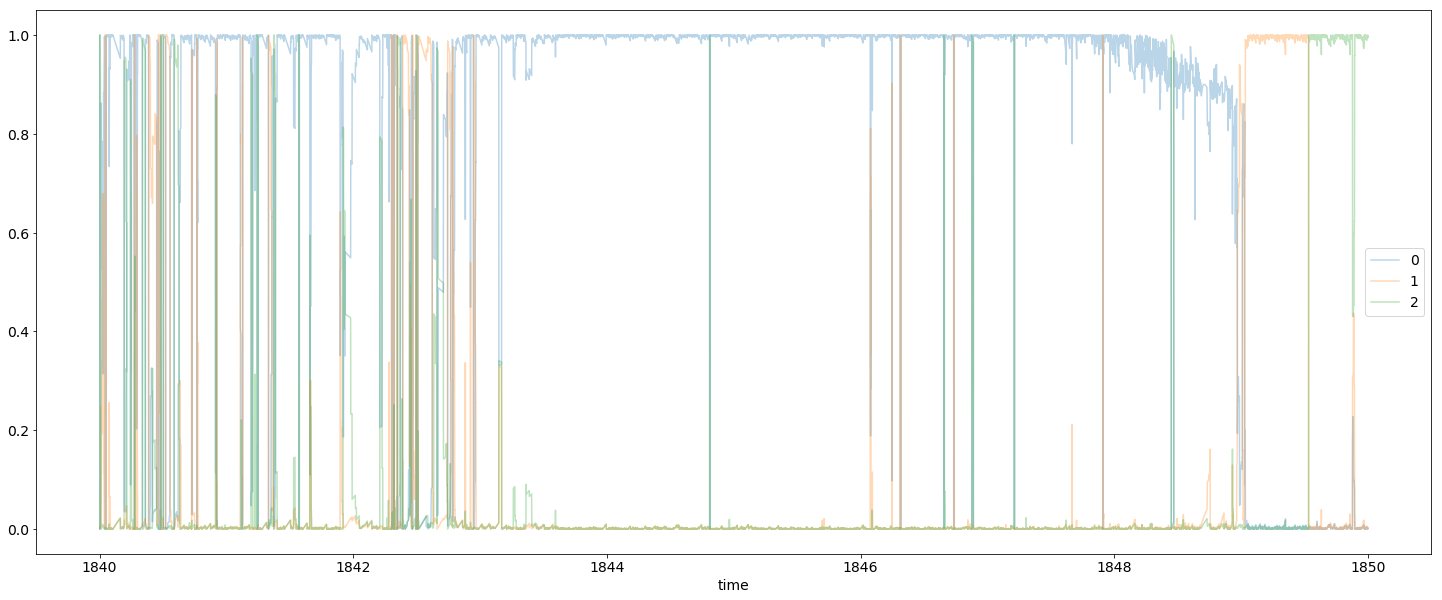

In [245]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(25, 5))
armmass.query('time > 1840 & time < 1850').plot(kind='line', x='time',y=[0,1,2], ax=axes, alpha=.3)
# means.loc[1840:1845,:].plot(kind='line', x='time',y=[0,1,2], ax=axes[1], alpha=.3)

In [259]:
# fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(25, 25))
data=armmass.drop('time', axis=1).query('time > 1840 & time < 1850')
# g = sns.PairGrid(data, diag_sharey=False)
# g.map_lower(sns.kdeplot, cmap="Blues_d")
# g.map_upper(plt.scatter)
# g.map_diag(sns.kdeplot, lw=3)

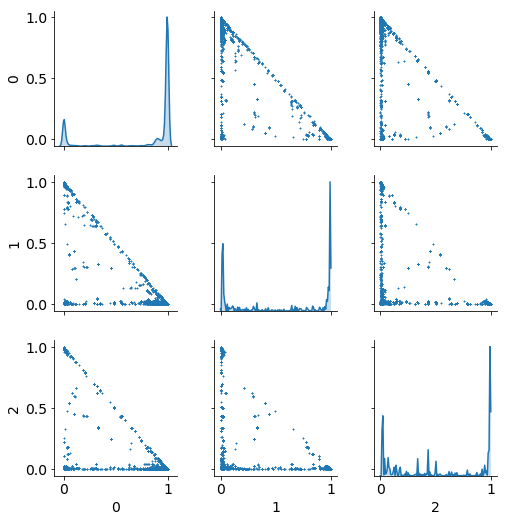

In [260]:
g = sns.pairplot(data, diag_kind="kde", markers="+",
                  plot_kws=dict(s=2, edgecolor="b", linewidth=1),
                  diag_kws=dict(shade=True))

In [ ]:
sns.pairplot(armmass.drop('time', axis=1).query('time > 1840 & time < 1850'), hue=)

In [123]:
from bokeh.models.
source = ColumnDataSource(centerstuff)

NameError: name 'ColumnDataSource' is not defined